## Project Goals

A distribution company that was recently a victim of fraud has completed an audit of various samples of wine through the use of chemical analysis on samples. The distribution company specializes in exporting extremely high quality, expensive wines, but was defrauded by a supplier who was attempting to pass off cheap, low quality wine as higher grade wine. The distribution company has hired you to attempt to create a machine learning model that can help detect low quality (a.k.a "fraud") wine samples. They want to know if it is even possible to detect such a difference.

### Import Libraries


In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

In [3]:
#Load Database of Wine test
df = pd.read_csv("../DATA/wine_fraud.csv")

In [4]:
#Check header of the data loaded (First 5 rows)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Legit,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,Legit,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,Legit,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,Legit,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Legit,red


In [5]:
#Check the variables of the column to predict
df["quality"].unique()

array(['Legit', 'Fraud'], dtype=object)

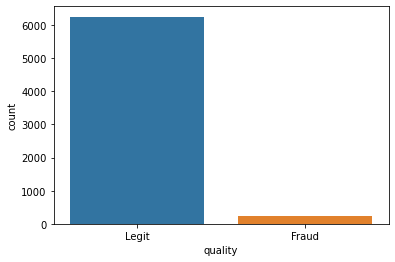

In [8]:
#Check if the dataset is balanced on the target variable
sns.countplot(x="quality", data=df)

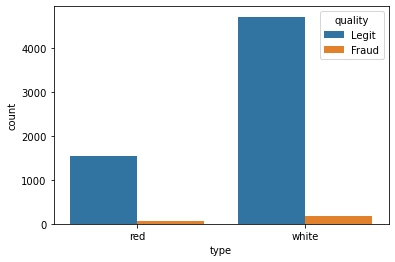

In [9]:
sns.countplot(x="type", hue="quality", data=df)

In [12]:
#The target is very unbalanced in general and in both type of wines
print("Percentage of fraud in Red Wines:")
print(len(df[(df["type"] == "red")&(df["quality"] == "Fraud")])/len(df[(df["type"] == "red")])*100)
print("Percentage of fraud in White Wines:")
print(len(df[(df["type"] == "white")&(df["quality"] == "Fraud")])/len(df[(df["type"] == "white")])*100)

Percentage of fraud in Red Wines:
3.9399624765478425
Percentage of fraud in White Wines:
3.7362188648427925


In [22]:
#To Measure correlation between target variable, its created a new variable, where the quality its mapped to 0(Legit) and 1(Fraud)
df["Fraud"]= df["quality"].map({'Legit': 0, 'Fraud': 1})
Correlation_Fraud = df.corr()["Fraud"].sort_values()

(-0.15, 0.15)

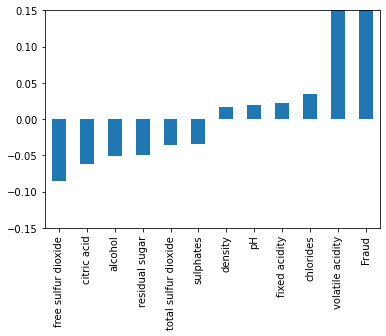

In [23]:
Correlation_Fraud.plot(kind='bar')
plt.ylim(-0.15,0.15)

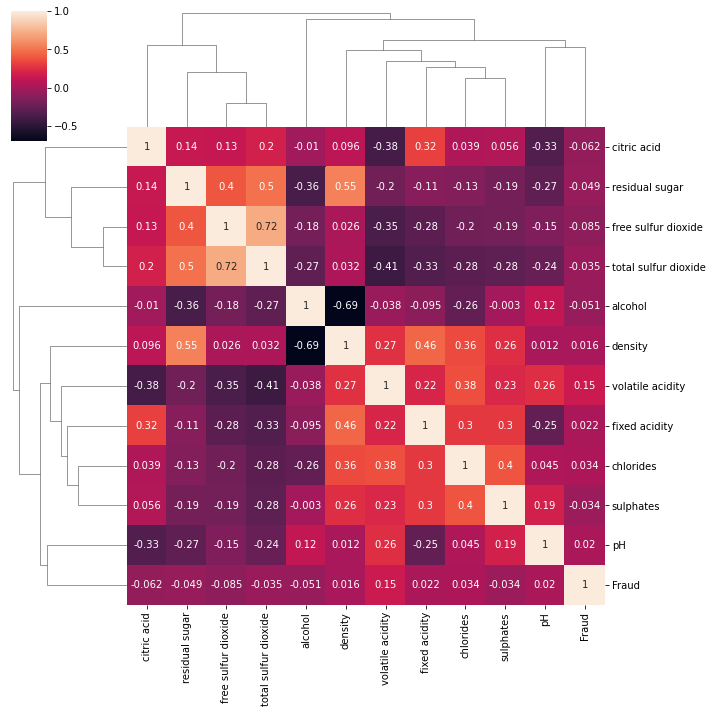

In [24]:
#Review correlation between variables
sns.clustermap(df.corr(), annot=True)

In [25]:
#Convert categorical columns in to dummy variables and drop the Fraud column created for correlation
df["type"] = pd.get_dummies(df["type"], drop_first=True)
df = df.drop('Fraud',axis=1)

0       0
1       0
2       0
3       0
4       0
       ..
6492    1
6493    1
6494    1
6495    1
6496    1
Name: type, Length: 6497, dtype: uint8

In [28]:
#Separate dataset into X(features) and y(pred target)
X = df.drop("quality", axis=1)
y = df["quality"]

In [31]:
#train test split your data for separate data in training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

In [32]:
#Create a pipeline, with the model and the preoprocessing steps
scaler = StandardScaler()
Svc = SVC(class_weight="balanced")
operations = [("scaler", scaler),("Svc", Svc)]
pipe = Pipeline(operations)

In [35]:
#Create a param_grid to try different values of C and different values of the gamma parameter
#Istanciate the model in the gridsearch with CV default 5
param_grid = {"Svc__C": [0.001, 0.01, 0.1, 1], "Svc__gamma":['scale','auto']}
grid = GridSearchCV(pipe, param_grid)
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('Svc', SVC(class_weight='balanced'))]),
             param_grid={'Svc__C': [0.001, 0.01, 0.1, 1],
                         'Svc__gamma': ['scale', 'auto']})

In [36]:
#Best params for all the combinations selected
grid.best_params_

{'Svc__C': 1, 'Svc__gamma': 'scale'}

In [39]:
#review metrics
y_pred = grid.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[ 17,  10],
       [ 92, 531]])

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Fraud       0.16      0.63      0.25        27
       Legit       0.98      0.85      0.91       623

    accuracy                           0.84       650
   macro avg       0.57      0.74      0.58       650
weighted avg       0.95      0.84      0.88       650



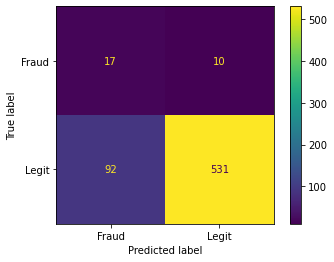

In [45]:
plot_confusion_matrix(grid, X_test,y_test)

Reviewing the F1-Score,the precision and recall for Fradulent wines, we couldn't generalize this model for the real world, because first the F1-Score its too low for fraud and we want to determinate the fraudulent wines, and in this moment we are misclassifying oh most the 40% of fraudulent wines.
The accuracy its high due to the unbalanced of the dataset, so accuracy its not a good measure for this dataset, also the recall and presicion are very different comparing against accuracy.
The recommendation will be to measure the quality of the wines select other features more than just chemical features, because this model its not so good based on this features.